In [1]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from urllib.parse import urlparse
import os
import numpy as np
from IPython.display import clear_output, display
import time
import pandas as pd
from Constants import Constants, specialTokenList, specialTokens
from All_Models import SSCL, GatedCNN, SelfAttnModel
from utils import getSampler
from LoadData import loadingTweetsAndUserInfoData
import torch
from Trainers import MultiTaskTrainer
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader


%matplotlib inline


'''
TODO:

1. Mardularize 
2. Pickle the output
3. Training


'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Using inplace method for the dat
class args(object):

    # Data
    
    dataset = "HSpam14"
    full_data = True
    usingWeightRandomSampling = True
    vocab_size = 30000 # if we create the new vocab size, we have to do the new preprocess again
    validation_portion = 0.05
    test_portion = 0.1
    random_seed = 64
    
    pickle_name = "TweetsAndExtraInfoFullPickleData" + str(vocab_size) + "Vocab.txt"
    pickle_name_beforeMapToIdx = "TweetsAndExtraInfoFullPickleData_df.txt"

    ##### Arch
    
    MultiTask_FCHidden = 16
    textModel_outDim = 16
    infoModel_outDim = 16
    combine_dim = 32
    
    usnig_infoModel = True
    using_textModel = True
    
    if !(using_infoModel and using_textModel):
        if using_infoModel:
            infoModel_outDim = 1
        elif using_textModel:
            textModel_outDim = 1
        else:
            raise ValueError('You must have to select infoModel or textModel')

    ## GatedCNN arch

    GatedCNN_embedingDim = 128
    GatedCNN_convDim = 64
    GatedCNN_kernel = 3
    GatedCNN_stride = 1
    GatedCNN_pad = 1
    GatedCNN_layers = 8
    GatedCNN_dropout = 0.1
        
    ## SSCL arch
    
    SSCL_embedingDim = 512
    SSCL_RNNHidden = 256
    SSCL_CNNDim = 256
    SSCL_CNNKernel = 5
    SSCL_CNNDropout = 0.1
    SSCL_LSTMDropout = 0.1
    SSCL_LSTMLayers = 1
    
    ## Attn arch

    SelfAttn_LenMaxSeq = 280 # Default, will be changed Later

    # These Two has to be the same
    
    SelfAttn_WordVecDim = 128
    SelfAttn_ModelDim = 128
    
    SelfAttn_FFInnerDim = 256
    SelfAttn_NumLayers = 3
    SelfAttn_NumHead = 4
    SelfAttn_KDim = 64
    SelfAttn_VDim = 64
    SelfAttn_Dropout = 0.1
    
    # Training params
    
    batch_size = 64
    L2 = 0.1
    threshold = 0.5
    lr = 0.0002
    n_epoch = 50

    # If using Adam
    
    adam_beta1 = 0.9
    adam_beta2 = 0.999
    
    earlyStopStep = None # Set None if we don't want it
    earlyStopEpoch = 1 #

    # Logging the Training
    
    val_freq = 50
    val_steps = 3
    log_freq = 10
    model_save_freq = 1
    model_name = 'TestingModel'
    model_path = './'+ dataset +'_Log/' + model_name + '/Model/'
    log_path = './' + dataset +'_Log/' + model_name + '/Log/'
    
args.device = device

# Create the path for saving model and the log
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

if not os.path.exists(args.log_path):
    os.makedirs(args.log_path)
    

In [2]:
training_dataset, validation_dataset, test_dataset, tweets_text = loadingTweetsAndUserInfoData(args)

Loading Existing File:  HSpam14/UserAndTweetsFullPickleData8000Vocab.txt


In [5]:
args.numberOfSpammer = sum([t[-1] for t in training_dataset])
args.numberOfNonSpammer = len(training_dataset)-args.numberOfSpammer
args.len_max_seq = training_dataset[0][2]

print("Number of Spammer: ", args.numberOfSpammer)
print("Number of NonSpammer: ", args.numberOfNonSpammer)

Number of Spammer:  tensor(192994.)
Number of NonSpammer:  tensor(894885.)


In [6]:
if args.usingWeightRandomSampling:
    sampler = getSampler(training_dataset)
else:
    sampler = None

train_loader = DataLoader(
    training_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False, sampler = sampler)
valid_loader = DataLoader(
    validation_dataset, batch_size=args.batch_size, shuffle=True, drop_last=False)

trainer = MultiTaskTrainer(SelfAttnModel, args).to(device)

print("Number of Parameters in this Model: ",trainer.num_all_params())
print("Using device: ", device)

scheduler = optim.lr_scheduler.StepLR(trainer.optim, 2000, gamma=0.85)
# trainer.optim.param_groups[0]['lr']=
allStep = 0
epoch = 0

/home/chihcheng/python3env/lib/python3.6/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


Number of Parameters in this Model:  1660849
Using device:  cuda


In [7]:
print("Model Structure: \n", trainer.model)

Model Structure: 
 MultiTaskModel(
  (textModel): SelfAttnModel(
    (encoder): Encoder(
      (src_word_emb): Embedding(8000, 128, padding_idx=0)
      (position_enc): Embedding(281, 128)
      (layer_stack): ModuleList(
        (0): EncoderLayer(
          (slf_attn): MultiHeadAttention(
            (w_qs): Linear(in_features=128, out_features=256, bias=True)
            (w_ks): Linear(in_features=128, out_features=256, bias=True)
            (w_vs): Linear(in_features=128, out_features=256, bias=True)
            (attention): ScaledDotProductAttention(
              (dropout): Dropout(p=0.1)
              (softmax): Softmax()
            )
            (layer_norm): LayerNorm(torch.Size([128]), eps=1e-05, elementwise_affine=True)
            (fc): Linear(in_features=256, out_features=128, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (pos_ffn): PositionwiseFeedForward(
            (w_1): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
            (w_2): Conv1

TrainConfusion Matrix: 



,0,1
0,30,2
1,4,28


ValConfusion Matrix: 



,0,1
0,44,6
1,5,9


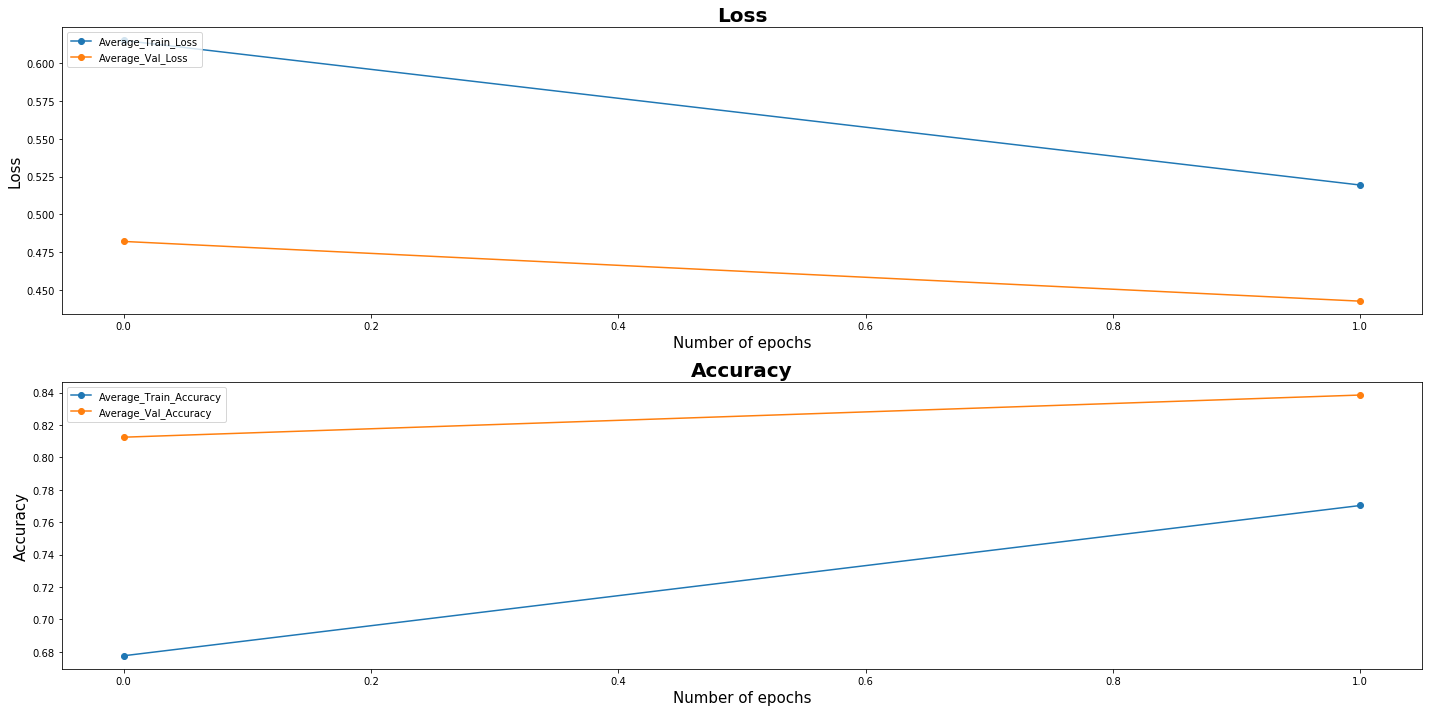

| Epoch [0] | Step [101] | lr [0.000200] | Loss: [0.4371] | Acc: [0.8594] | Time: 0.0s
| Epoch [0] | Step [102] | lr [0.000200] | Loss: [0.4492] | Acc: [0.8438] | Time: 0.0s
| Epoch [0] | Step [103] | lr [0.000200] | Loss: [0.5522] | Acc: [0.8125] | Time: 0.0s
| Epoch [0] | Step [104] | lr [0.000200] | Loss: [0.4362] | Acc: [0.8281] | Time: 0.0s
| Epoch [0] | Step [105] | lr [0.000200] | Loss: [0.4511] | Acc: [0.8281] | Time: 0.0s
| Epoch [0] | Step [106] | lr [0.000200] | Loss: [0.4543] | Acc: [0.8594] | Time: 0.0s
| Epoch [0] | Step [107] | lr [0.000200] | Loss: [0.4184] | Acc: [0.8594] | Time: 0.0s
| Epoch [0] | Step [108] | lr [0.000200] | Loss: [0.5447] | Acc: [0.7656] | Time: 0.0s
| Epoch [0] | Step [109] | lr [0.000200] | Loss: [0.4269] | Acc: [0.8125] | Time: 0.0s
| Epoch [0] | Step [110] | lr [0.000200] | Loss: [0.5195] | Acc: [0.7344] | Time: 0.0s


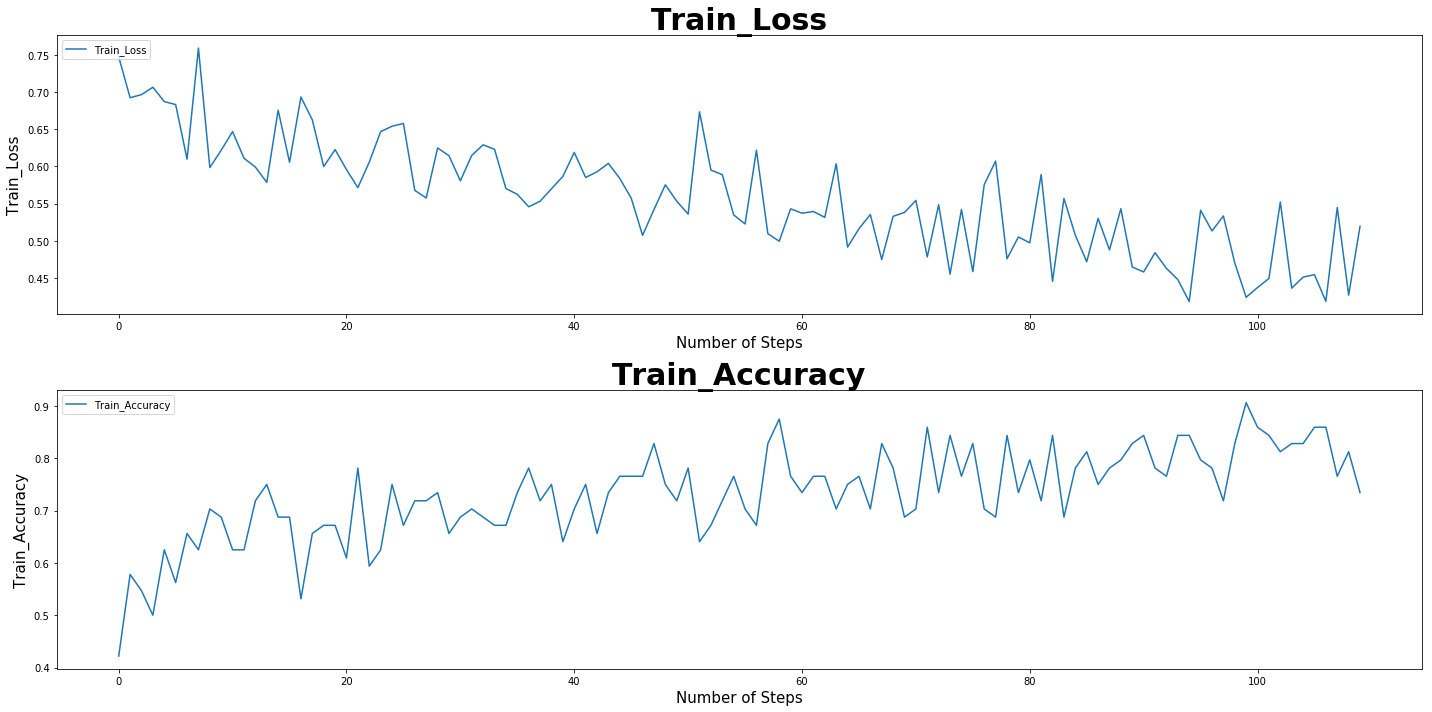

| Epoch [0] | Step [111] | lr [0.000200] | Loss: [0.4767] | Acc: [0.7969] | Time: 0.0s
| Epoch [0] | Step [112] | lr [0.000200] | Loss: [0.4589] | Acc: [0.7969] | Time: 0.0s
| Epoch [0] | Step [113] | lr [0.000200] | Loss: [0.4796] | Acc: [0.7969] | Time: 0.0s
| Epoch [0] | Step [114] | lr [0.000200] | Loss: [0.4447] | Acc: [0.8281] | Time: 0.0s
| Epoch [0] | Step [115] | lr [0.000200] | Loss: [0.4074] | Acc: [0.8906] | Time: 0.0s
| Epoch [0] | Step [116] | lr [0.000200] | Loss: [0.4566] | Acc: [0.7500] | Time: 0.0s
| Epoch [0] | Step [117] | lr [0.000200] | Loss: [0.4753] | Acc: [0.8281] | Time: 0.0s
| Epoch [0] | Step [118] | lr [0.000200] | Loss: [0.3926] | Acc: [0.8750] | Time: 0.0s
| Epoch [0] | Step [119] | lr [0.000200] | Loss: [0.4634] | Acc: [0.7812] | Time: 0.0s
| Epoch [0] | Step [120] | lr [0.000200] | Loss: [0.4114] | Acc: [0.8750] | Time: 0.0s


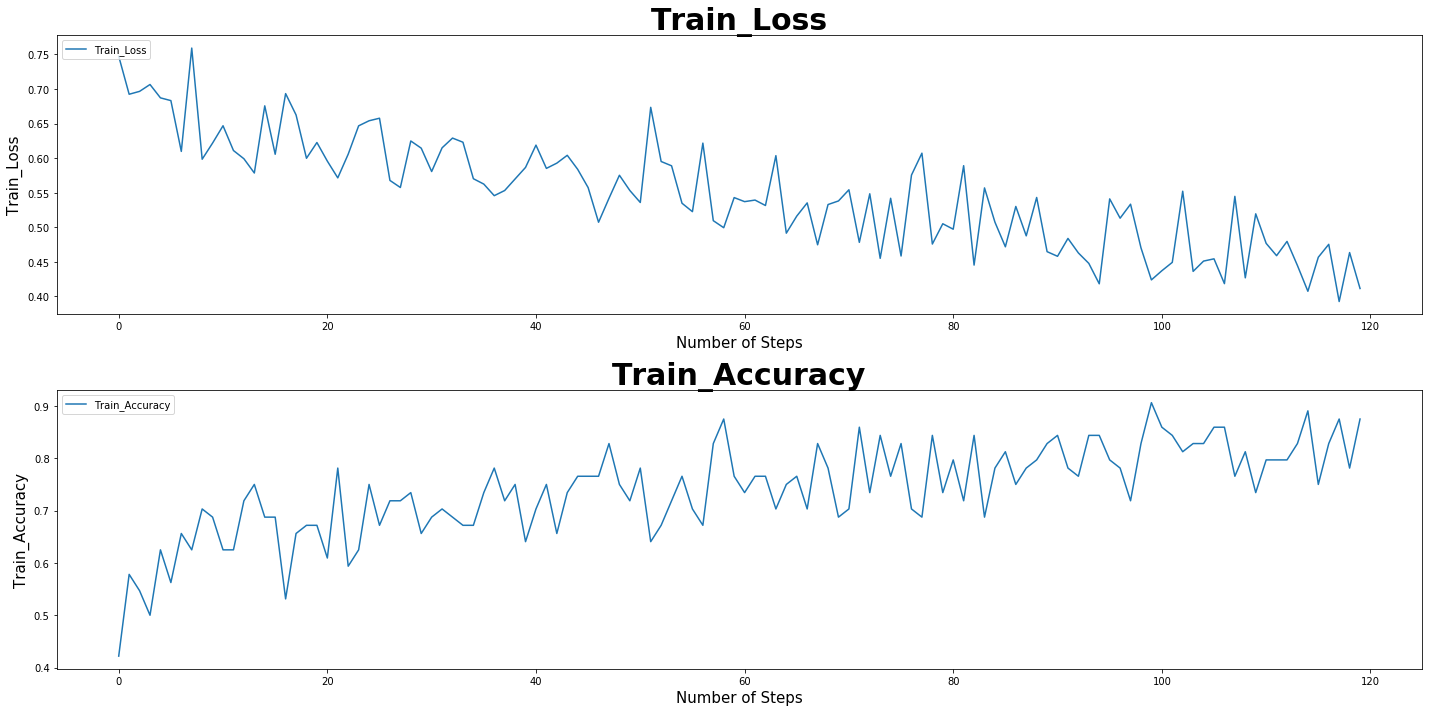

| Epoch [0] | Step [121] | lr [0.000200] | Loss: [0.4042] | Acc: [0.8438] | Time: 0.0s
| Epoch [0] | Step [122] | lr [0.000200] | Loss: [0.4386] | Acc: [0.8594] | Time: 0.0s
| Epoch [0] | Step [123] | lr [0.000200] | Loss: [0.4610] | Acc: [0.8594] | Time: 0.0s
| Epoch [0] | Step [124] | lr [0.000200] | Loss: [0.4356] | Acc: [0.8281] | Time: 0.0s
| Epoch [0] | Step [125] | lr [0.000200] | Loss: [0.4008] | Acc: [0.9062] | Time: 0.0s
| Epoch [0] | Step [126] | lr [0.000200] | Loss: [0.4306] | Acc: [0.8594] | Time: 0.0s
| Epoch [0] | Step [127] | lr [0.000200] | Loss: [0.4777] | Acc: [0.7812] | Time: 0.0s
| Epoch [0] | Step [128] | lr [0.000200] | Loss: [0.4005] | Acc: [0.9062] | Time: 0.0s
| Epoch [0] | Step [129] | lr [0.000200] | Loss: [0.4754] | Acc: [0.7656] | Time: 0.0s
| Epoch [0] | Step [130] | lr [0.000200] | Loss: [0.3963] | Acc: [0.9062] | Time: 0.0s


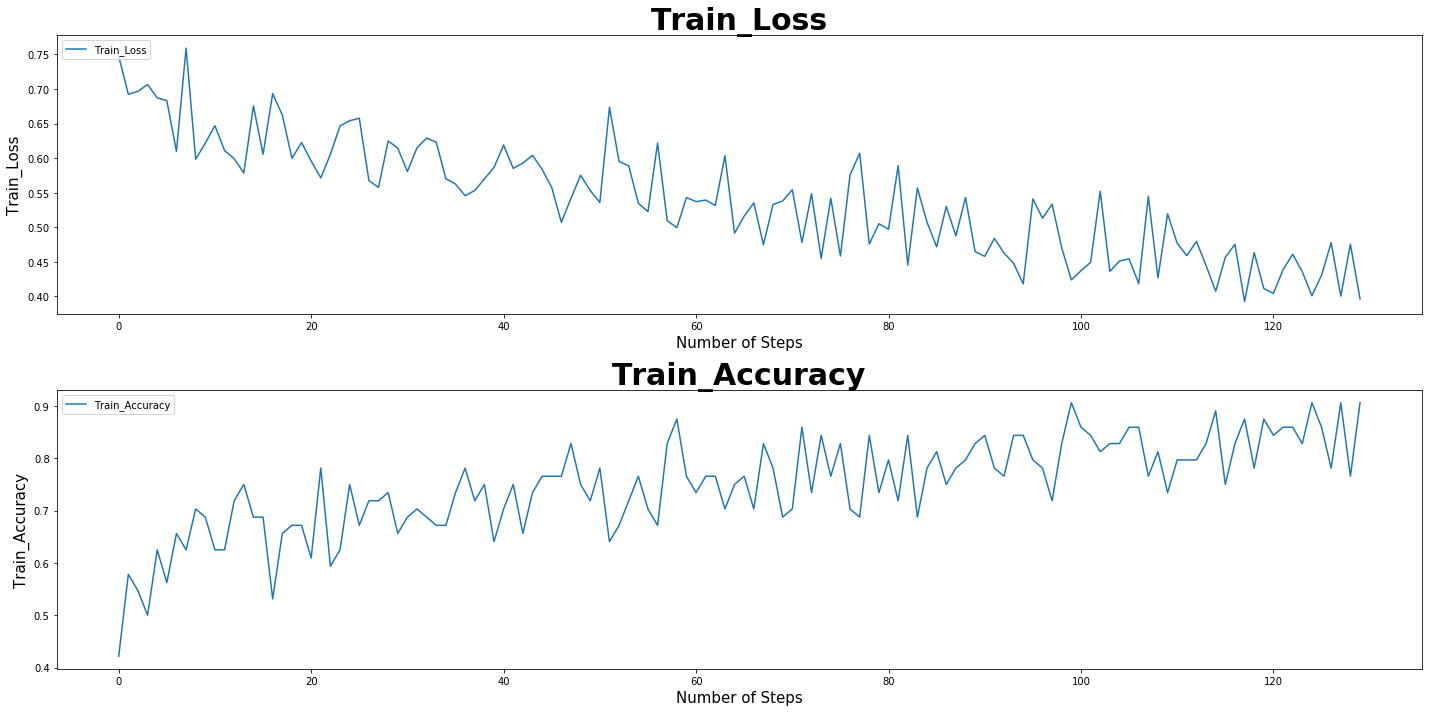

| Epoch [0] | Step [131] | lr [0.000200] | Loss: [0.4494] | Acc: [0.8125] | Time: 0.0s
| Epoch [0] | Step [132] | lr [0.000200] | Loss: [0.5077] | Acc: [0.7500] | Time: 0.0s
| Epoch [0] | Step [133] | lr [0.000200] | Loss: [0.5230] | Acc: [0.7188] | Time: 0.0s
| Epoch [0] | Step [134] | lr [0.000200] | Loss: [0.4936] | Acc: [0.8594] | Time: 0.0s
| Epoch [0] | Step [135] | lr [0.000200] | Loss: [0.4665] | Acc: [0.8438] | Time: 0.0s
| Epoch [0] | Step [136] | lr [0.000200] | Loss: [0.4897] | Acc: [0.8438] | Time: 0.0s
| Epoch [0] | Step [137] | lr [0.000200] | Loss: [0.4698] | Acc: [0.7812] | Time: 0.0s
| Epoch [0] | Step [138] | lr [0.000200] | Loss: [0.4533] | Acc: [0.8438] | Time: 0.0s
| Epoch [0] | Step [139] | lr [0.000200] | Loss: [0.5176] | Acc: [0.7812] | Time: 0.0s
| Epoch [0] | Step [140] | lr [0.000200] | Loss: [0.4679] | Acc: [0.7656] | Time: 0.0s


KeyboardInterrupt: 

In [8]:
while epoch < args.n_epoch:
    for i, (text, extra_info, length, label) in enumerate(train_loader):
        
        trainer.train()
        text, extra_info, length, label = text.to(device), extra_info.to(device), length.to(device), label.to(device)
        
#         if trainer.optim.param_groups[0]['lr'] >= 0.0001:
#             scheduler.step()
        start_t = time.time()
#         trainer.train_step(((text, extra_info),length), label)
        trainer.train_step(((text, extra_info),None), label)
        

        end_t = time.time()
        allStep += 1
        print('| Epoch [%d] | Step [%d] | lr [%.6f] | Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %
              (epoch, allStep, trainer.optim.param_groups[0]['lr'], trainer.loss.item(), trainer.accuracy.item(),
               end_t - start_t))
        
#         if trainer.accuracy.item() > 0.95: # Stop early
#             raise StopIteration
        if allStep % args.log_freq == 0:
            trainer.plot_train_hist(args.model_name)
            
        
        if args.earlyStopStep:
            if allStep >= args.earlyStopStep:
                    raise StopIteration
        

        if allStep % args.val_freq == 0:

            for _ in range(args.val_steps):
                trainer.eval()
                stIdx = np.random.randint(
                    0, len(validation_dataset) - args.batch_size)
                v_text, v_extra_info, v_len, v_label = validation_dataset[stIdx: stIdx +
                                                       args.batch_size]
                v_text, v_extra_info, v_len, v_label = v_text.to(device), v_extra_info.to(device), v_len.to(device), v_label.to(device)
                start_t = time.time()
#                 trainer.test_step(((v_text, v_extra_info),v_len), v_label)
                trainer.test_step(((v_text, v_extra_info),None), v_label)
                
                end_t = time.time()
                print('| Epoch [%d] | Validation | Step [%d] |  Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %
                      (epoch, allStep, trainer.loss.item(), trainer.accuracy.item(), end_t - start_t))
            trainer.calculateAverage()
            clear_output()
            print("TrainConfusion Matrix: \n")
            display(pd.DataFrame(trainer.cms['Train'][-1]))
            print("ValConfusion Matrix: \n")
            display(pd.DataFrame(trainer.cms['Val'][-1]))
            trainer.plot_all(args.model_name)
            
            
     # After every Epoch, if can be moved

    epoch += 1
    trainer.model_save(epoch)

    if args.earlyStopEpoch:
        if epoch >= args.earlyStopEpoch:
            raise StopIteration

In [9]:
test_loader = DataLoader(
    test_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False)
test_accs = []
test_cms = []
trainer.eval()
for i, (test_text, test_extra_info, test_length, test_label) in enumerate(test_loader):
    test_text, test_extra_info, test_length, test_label = test_text.to(device), test_extra_info.to(device), test_length.to(device), test_label.to(device)
    test_loss, test_accuracy, test_cm = trainer.test_step(((test_text, test_extra_info),None), test_label)
    test_accs.append(test_accuracy)
    test_cms.append(test_cm)
print("Test Accuracy: ", torch.mean(torch.tensor(test_accs)))
print("Test Confusion Matrix: \n", sum(test_cms))

Test Accuracy:  tensor(0.9075)
Test Confusion Matrix: 
 [[1781  104]
 [ 106  300]]
